In [1]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import cv2
import open3d as o3d

# Image Split

In [2]:
img = io.imread("D:/Library/Datasets/SYNTHIA-SF/SEQ2/RGBRight/0000500.png")
depth = io.imread("D:/Library/Datasets/SYNTHIA-SF/SEQ2/DepthRight/0000500.png")
focal_length = 847.630211643
# img = io.imread("D:/Library/Datasets/Apollo Synthetic/SampleData/RGB/06-00/HEAVY_RAIN/NO_DEGRADATION/With_Pedestrian/With_TrafficBarrier/Residential/Traffic_135/0000007.jpg")
# depth = io.imread("D:/Library/Datasets/Apollo Synthetic/SampleData/Depth/06-00/HEAVY_RAIN/NO_DEGRADATION/With_Pedestrian/With_TrafficBarrier/Residential/Traffic_135/0000007.png")

img = np.array(img[:,:,0:3], np.float32) / 256.0
depth = np.array(
                (depth[ :, :, 0] + depth[ :, :, 1] * 256.0 +
                 depth[ :, :, 2] * 256 * 256.0) / ((256 * 256 * 256) - 1),
                dtype=np.float32) * 1000

In [3]:
s_height = 512
s_width = 512
i_height = img.shape[0]
i_width = img.shape[1]

In [4]:
row_num = int(np.ceil(i_height/s_height))
column_num = int(np.ceil(i_width/s_width))

In [5]:
column_step = int( np.floor((i_height - s_height)/row_num) )
row_step = int( np.floor((i_width - s_width)/column_num) ) 

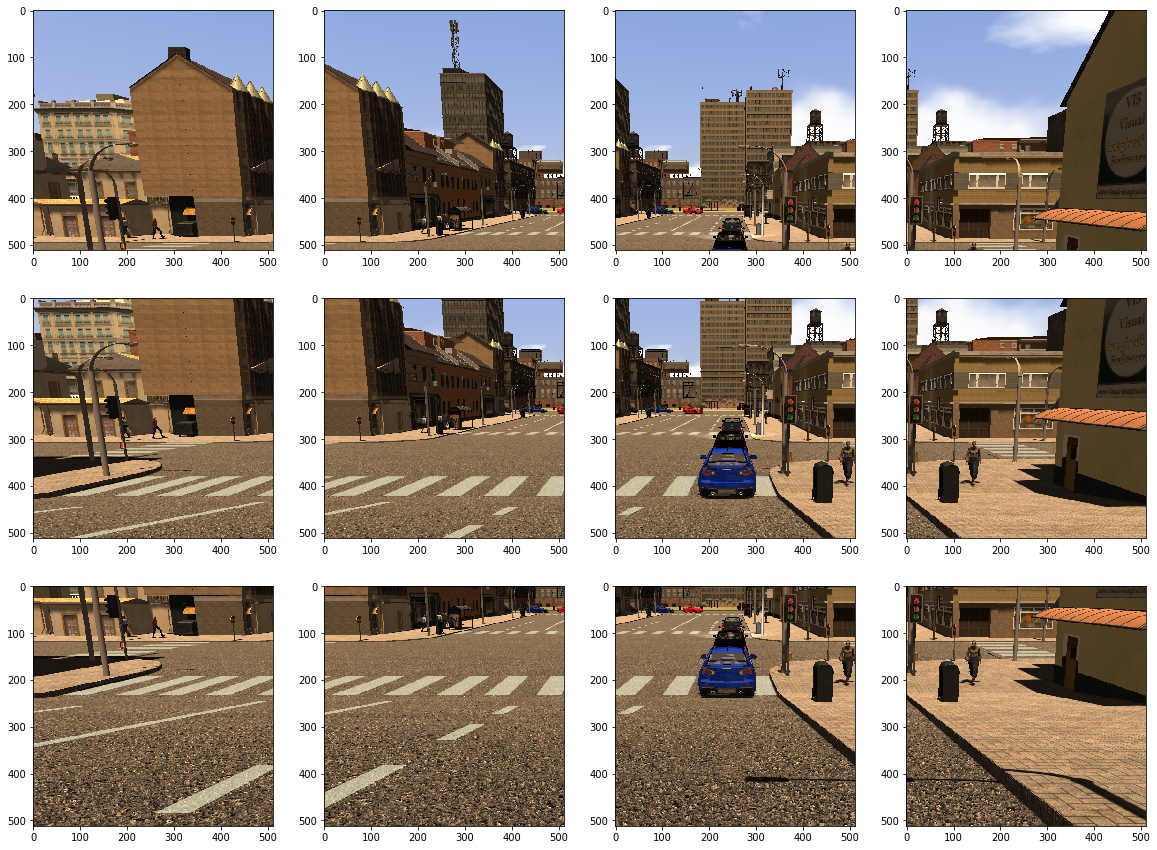

In [6]:
plt.figure(figsize=(5*column_num, 5*row_num))
# x = []
for row in range(row_num):
    for column in range(column_num):
        plt.subplot(row_num, column_num, row*column_num + column + 1)
        plt.imshow(img[column_step*row : s_height + column_step*row, 
                       row_step*column : s_width + row_step*column])
#         x.append(img[column_step*row : s_height + column_step*row, 
#                        row_step*column : s_width + row_step*column])

# Image Sub-sampling

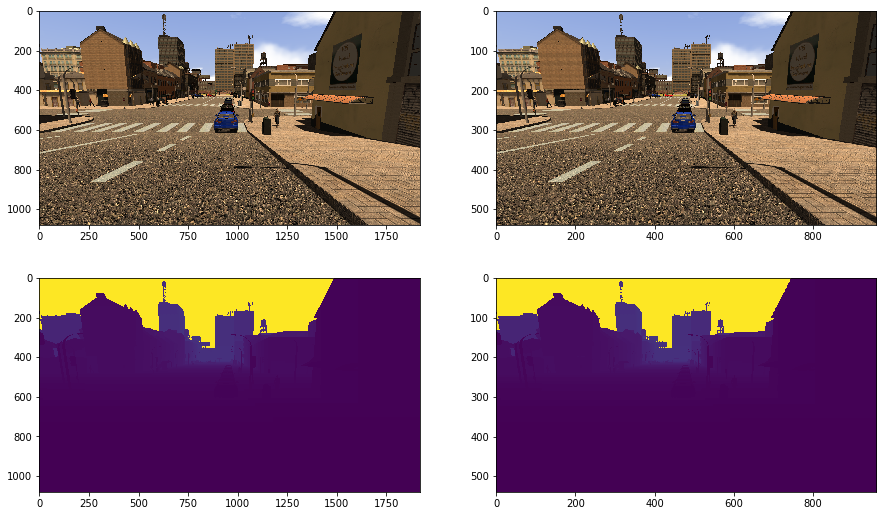

In [7]:
plt.figure(figsize=(15,9))
plt.subplot(2,2,1)
plt.imshow( img)
plt.subplot(2,2,2)
plt.imshow( img[0:i_height:2, 0:i_width:2] )

plt.subplot(2,2,3)
plt.imshow( depth)
plt.subplot(2,2,4)
plt.imshow( depth[0:i_height:2, 0:i_width:2] )

# Image Resizing with nearest neighbor interpolation

In [8]:
h_ratio = i_height/s_height
w_ratio = i_width/s_width
print("h_ratio: {}, w_ratio: {}".format(h_ratio, w_ratio))
max_ratio = max(h_ratio, w_ratio)
resize_ratio = 3 / max_ratio
resize_ratio

h_ratio: 2.109375, w_ratio: 3.75


0.8

In [9]:
dims = (int(img.shape[1]*resize_ratio), int(img.shape[0]*resize_ratio))
if (img.shape[1]*resize_ratio + img.shape[0]*resize_ratio) % 1 > 0:
    print("Cropping occurred in resize!")
resized_img = cv2.resize(img, dims,  interpolation = cv2.INTER_NEAREST)
resized_depth = cv2.resize(depth, dims, interpolation = cv2.INTER_NEAREST)

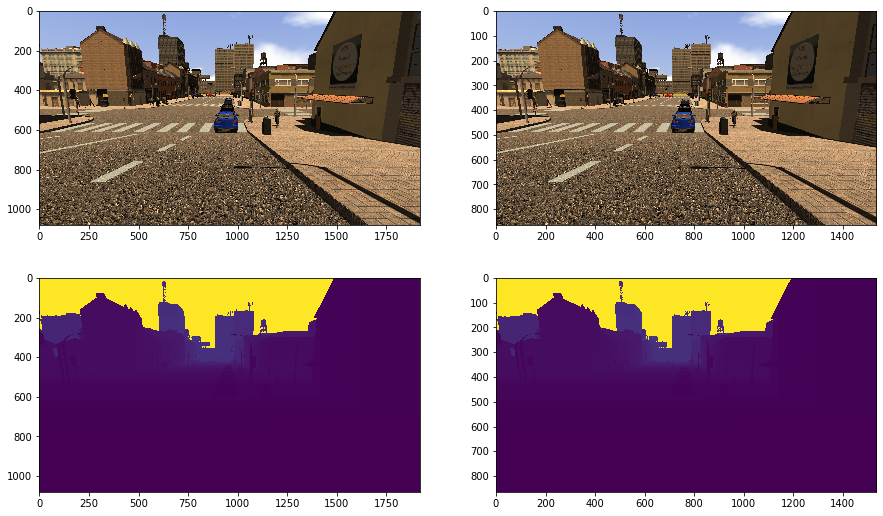

In [10]:
plt.figure(figsize=(15,9))
plt.subplot(2,2,1)
plt.imshow( img)
plt.subplot(2,2,2)
plt.imshow( resized_img )

plt.subplot(2,2,3)
plt.imshow( depth)
plt.subplot(2,2,4)
plt.imshow( resized_depth )

# Image Resizing and Splitting

In [103]:
resize_ratio=0.8#1#

In [104]:
dims = (int(img.shape[1]*resize_ratio), int(img.shape[0]*resize_ratio))
if (img.shape[1]*resize_ratio + img.shape[0]*resize_ratio) % 1 > 0:
    print("Cropping occurred in resize!")
resized_img = cv2.resize(img, dims,  interpolation = cv2.INTER_NEAREST)
resized_depth = cv2.resize(depth, dims, interpolation = cv2.INTER_NEAREST)
resized_focal = focal_length*resize_ratio

In [105]:
s_height = 512
s_width = 512
i_height = resized_img.shape[0]
i_width = resized_img.shape[1]

In [106]:
row_num = int(np.ceil(i_height/s_height))
column_num = int(np.ceil(i_width/s_width))

In [107]:
column_step = int( np.floor((i_height - s_height)/row_num) )
row_step = int( np.floor((i_width - s_width)/column_num) ) 

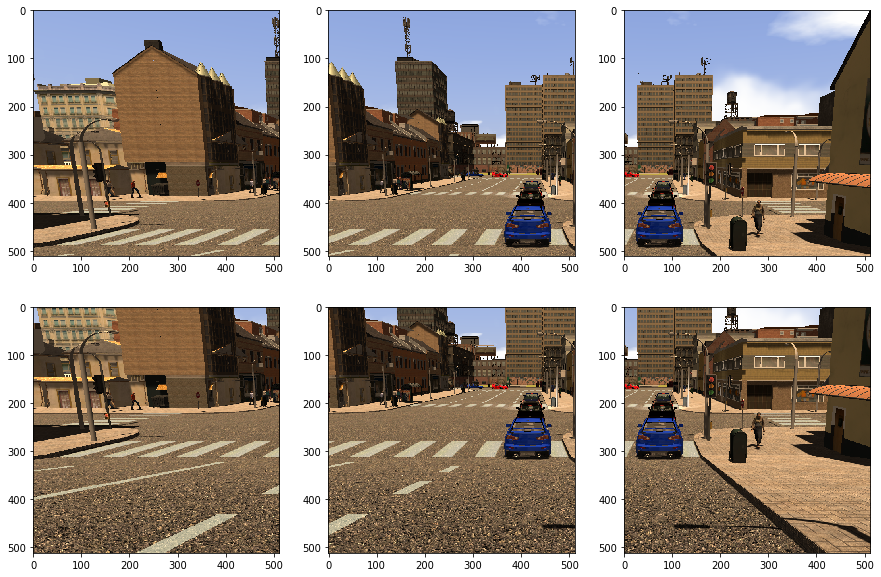

In [108]:
plt.figure(figsize=(5*column_num, 5*row_num))
# x = []
for row in range(row_num):
    for column in range(column_num):
        plt.subplot(row_num, column_num, row*column_num + column + 1)
        plt.imshow(resized_img[column_step*row : s_height + column_step*row, 
                       row_step*column : s_width + row_step*column])
#         x.append(img[column_step*row : s_height + column_step*row, 
#                        row_step*column : s_width + row_step*column])

### 3D visualiztion

In [109]:
# img_vis = img
# depth_vis = depth
# focal_vis = focal_length

img_vis = resized_img
depth_vis = resized_depth
focal_vis = resized_focal

In [110]:
feature_list =[np.expand_dims(img_vis, 0) ]
label_list=[np.expand_dims(np.expand_dims(depth_vis, 0), -1)]

In [111]:
feature_list[0].shape

(1, 864, 1536, 3)

In [112]:
a = o3d.geometry.Image(img_vis)
b = o3d.geometry.Image(depth_vis)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(a, b, depth_scale=1, depth_trunc=3000)

In [113]:
x = o3d.camera.PinholeCameraIntrinsic(width=img_vis.shape[1],
                                      height=img_vis.shape[0],
                                      fx= focal_vis,
                                      fy= focal_vis,
                                      cx=img_vis.shape[1]/2-.5,
                                      cy=img_vis.shape[0]/2-.5)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(  #pylint: disable=no-member
        rgbd_image,x)

rgb_vector = np.reshape(img_vis, [-1, 3])
pcd.colors = o3d.utility.Vector3dVector(rgb_vector)  #pylint: disable=no-member
o3d.visualization.draw_geometries([pcd])  #pylint: disable=no-member

In [114]:
o3d.io.write_point_cloud("Unormal.ply", pcd)

True

# codddy1

In [28]:
from collections import namedtuple
from typing import NamedTuple
class Employee(NamedTuple):
    name: str
    id: int
# Employee = namedtuple('Employee', ['name', 'id'])

In [32]:
class GeneratorSettings(NamedTuple):
    usage: str = 'train'
    usage_range: tuple = (0, 1)
    auto_restart: bool = True #repeater
    shuffle: bool = True
    shuffle_seed: str = 123
    batch_size: int = 1
        
class DataSettings(NamedTuple):
    float_type: str
    auto_restart: bool #repeater
    shuffle: bool
    shuffle_seed: str
    batch_size: int
    output_shape: tuple = (512, 512)

In [35]:
from enum import Enum, auto
import numpy as np
class Usage(Enum):
    TRAIN = auto()
    VALIDATION = auto()
    TEST = auto()
class DataType(Enum):
    RGB = auto()
    SEGMENTATION = auto()
    INSTANCE = auto()
    DEPTH = auto()
    
from dataclasses import dataclass
@dataclass
class GeneratorSettings:
    usage: str = 'train'
    usage_range: tuple = (0, 1)
    auto_restart: bool = True #repeater
    shuffle: bool = True
    shuffle_seed: str = 123
    batch_size: int = 1
        
@dataclass        
class DataSpecification:
    input_types: list
    output_types: list
    seg_ids: list
    output_shape: tuple = (512, 512)
    float_type: type = np.float32

In [41]:
@dataclass        
class DataSpecs:
#     name: str
    class_ids: list
    sensor_type: str
    calibration: dict  

In [39]:
@dataclass        
class DataGroupSpecs:
    input_types: list
    output_types: list
    split_to_windows: bool
    desired_focal: float
    output_shape: tuple = (512, 512)
    float_type: type = np.float32

In [42]:
image = DataSpecs([1], 'camera', {'focal':830})

(0.0, 1.0, 0.0, 1.0)

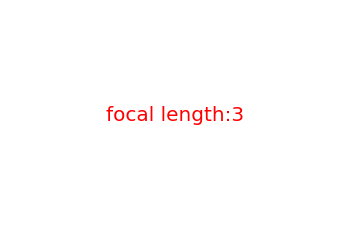

In [127]:
plt.text(0.5,0.5,"focal length:{}".format(3),fontsize=20, color='red',
        horizontalalignment='center',
        verticalalignment='center',)
plt.axis('off')